In [ ]:
!unzip /content/PINN-CGM-1.zip

Archive:  /content/PINN-CGM-1.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/PINN-CGM-1.zip or
        /content/PINN-CGM-1.zip.zip, and cannot find /content/PINN-CGM-1.zip.ZIP, period.


In [ ]:
%cd PINN-CGM-master

/content/PINN-CGM-master


In [ ]:
!python data.py
!python utils.py


In [ ]:
!pip install pyswarm
import pyswarm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from scipy.integrate import odeint
from pyswarm import pso

In [ ]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

import sys
sys.path.append('/content/PINN-CGM-1/simglucose')

from collections import namedtuple
from simglucose.patient.t1dpatient import T1DPatient

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

You could install pathos to enable parallel simulation.


In [ ]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"

# better plots
sns.set()

# tqdm
tqdm.pandas()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# load dataset
c3r = C3RData(data_dir="/content/PINN-CGM-1/data")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-06 00:00:00"


# destructure data
cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
data_t, data_CGM, data_CHO, data_insulin = interpolate(cgm_data, meal_data, insulin_data)

# normalize time
data_t -= data_t[0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


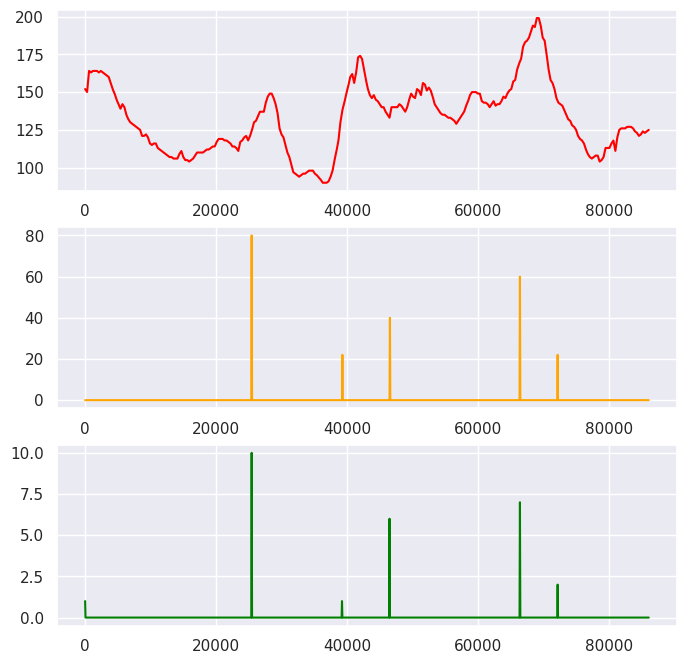

In [ ]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [ ]:
# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [ ]:
# load parameters
orig_params = pd.read_csv("/content/PINN-CGM-1/parameters/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_range = np.stack([adult_params.min(), adult_params.max()], axis=1)
def constrain_params(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return pd.Series({
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    })

In [ ]:
# time
t_span = (data_t[0], data_t[-1])
t_eval = data_t

# initial conditions
u0 = nominal_params.iloc[2:15].to_numpy()

def output(params):
    patient = T1DPatient.withParams(params)

    t_trace = t_eval # np.arange(*t_span)
    BG_trace = []
    # dx_trace = []

    for t in t_trace:
        # get current action
        t_mask = np.abs(data_t - t).argmin()
        action = Action(CHO=data_CHO[t_mask], insulin=data_insulin[t_mask])

        # track variables
        BG_trace.append(patient.observation.Gsub)
        # dx_trace.append(patient.derivative)

        patient.step(action)

    BG_trace = np.array(BG_trace)
    # dx_trace = np.array(derivatives)

    return t_trace, BG_trace #, dx_trace

In [ ]:
NGEN = 10
SIGMA = 5
LAMBDA = 20

# target function
def evaluate(p):
    try:
        pred_t, pred_CGM = output(construct_params(p))
        return [np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))]
    except:
        return [1e10]
# PSO parameters
N_PARTICLES = 20
N_ITERATIONS = 100
C1 = 1.49618
C2 = 1.49618
W = 0.729
# inital parameter guess
p_guess = adult_params.mean().to_numpy()

# PSO algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, velocity=list, best=None)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)

# initialize particles
def generate_particle():
    particle = creator.Particle(np.random.uniform(low=-1, high=1, size=len(p_guess)))
    particle.velocity = np.zeros_like(p_guess)
    particle.best = None
    return particle

toolbox.register("particle", generate_particle)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)

# define update function
def update_particle(particle, best_pos):
    r1 = np.random.uniform(0, 1, len(p_guess))
    r2 = np.random.uniform(0, 1, len(p_guess))
    
    # create a new particle object for the best position
    best_particle = Particle(best_pos)
    
    particle.velocity = (W * particle.velocity
                         + C1 * r1 * (particle.best - particle)
                         + C2 * r2 * (best_particle - particle))
    
    # update position
    particle.position += particle.velocity
    particle.position = np.clip(particle.position, lb, ub)
    
    # update personal best if necessary
    if evaluate(particle.position) < evaluate(particle.best):
        particle.best = np.copy(particle.position)
        particle.best_fitness = evaluate(particle.position)
    
    return particle


toolbox.register("update", update_particle)
# CMA-ES
strategy = cma.Strategy(centroid=p_guess, sigma=SIGMA, lambda_=LAMBDA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda particle: particle.best.fitness.values[0] if particle.best else np.inf)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


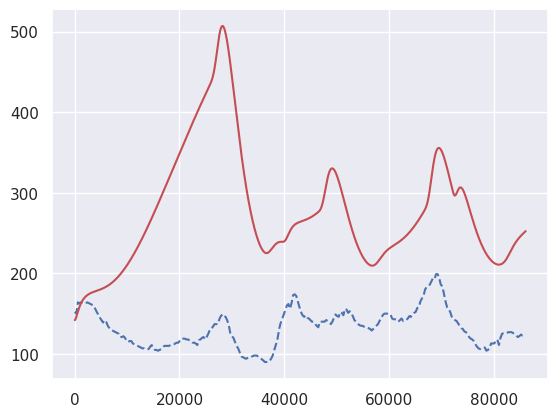

In [ ]:
p = adult_params.mean().to_numpy()
pred_t, pred_CGM = output(construct_params(p))
plt.plot(data_t, data_CGM, "b--")
plt.plot(pred_t, pred_CGM, "r")
plt.show()

In [ ]:
from IPython.display import clear_output

In [ ]:
# train loop
def train(toolbox, ngen, stats, halloffame):
    loss_history = []
    for _ in range(ngen):
        # generate a new population
        population = toolbox.generate()

        # evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(population)

        # update the strategy with the evaluated individuals
        toolbox.update(population)

        record = stats.compile(population) if stats is not None else {}
        loss_history.append(record["min_loss"])

        clear_output(wait=True)
        plt.plot(loss_history, "r.-")
        plt.show()

    return loss_history

In [ ]:
from pyswarm import pso

In [ ]:
import numpy as np
import pyswarms as ps

# target function
def evaluate(p):
    try:
        pred_t, pred_CGM = output(construct_params(p))
        return [np.sqrt(np.mean((np.log(pred_CGM + 1) - np.log(data_CGM + 1)) ** 2))]
    except:
        return [1e10]

# PSO algorithm setup
bounds = (np.zeros_like(p_guess), np.ones_like(p_guess))  # define bounds for each parameter
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}  # set PSO parameters

# instantiate PSO optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=len(p_guess), options=options, bounds=bounds)

# perform optimization
best_cost, best_params = optimizer.optimize(evaluate, iters=500)

# print results
print("Best cost:", best_cost)
print("Best parameters:", best_params)


2023-04-25 08:59:10,588 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=1e+10
2023-04-25 08:59:12,902 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10000000000.0, best pos: [0.50575558 0.18686914 0.70676566 0.30652757 0.34372933 0.31229774
 0.21190702 0.8562326  0.86377375 0.62313978]


Best cost: 10000000000.0
Best parameters: [0.50575558 0.18686914 0.70676566 0.30652757 0.34372933 0.31229774
 0.21190702 0.8562326  0.86377375 0.62313978]


2023-04-25 08:59:15,254 - simglucose.patient.t1dpatient - INFO - t = 424.0, patient starts eating ...
2023-04-25 08:59:15,380 - simglucose.patient.t1dpatient - INFO - t = 440.0, Patient finishes eating!
2023-04-25 08:59:15,935 - simglucose.patient.t1dpatient - INFO - t = 655.0, patient starts eating ...
2023-04-25 08:59:15,991 - simglucose.patient.t1dpatient - INFO - t = 660.0, Patient finishes eating!
2023-04-25 08:59:16,307 - simglucose.patient.t1dpatient - INFO - t = 776.0, patient starts eating ...
2023-04-25 08:59:16,358 - simglucose.patient.t1dpatient - INFO - t = 784.0, Patient finishes eating!
2023-04-25 08:59:17,146 - simglucose.patient.t1dpatient - INFO - t = 1107.0, patient starts eating ...
2023-04-25 08:59:17,243 - simglucose.patient.t1dpatient - INFO - t = 1119.0, Patient finishes eating!
2023-04-25 08:59:17,494 - simglucose.patient.t1dpatient - INFO - t = 1203.0, patient starts eating ...
2023-04-25 08:59:17,528 - simglucose.patient.t1dpatient - INFO - t = 1208.0, Patien

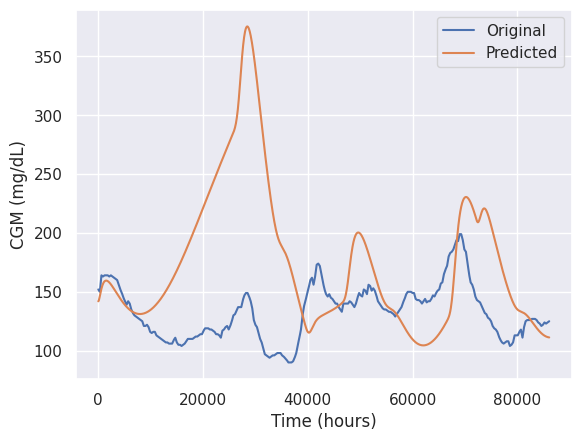

In [ ]:
opt_params = best_params
pred_t, pred_CGM = output(construct_params(opt_params))

# plot predicted and original curves
import matplotlib.pyplot as plt

plt.plot(data_t, data_CGM, label='Original')
plt.plot(pred_t, pred_CGM, label='Predicted')
plt.xlabel('Time (hours)')
plt.ylabel('CGM (mg/dL)')
plt.legend()
plt.show()